# [Instacart Market Basket Analysis - Kaggle](https://www.kaggle.com/c/instacart-market-basket-analysis)

인스타카트는 식료품 주문 및 배달 앱이다. 냉장고와 팬트리를 개인화된 취향에 맞춰 쉽게 채우는 것을 목표로 한다.

인스타카트의 데이터과학팀은 즐거운 쇼핑겸험을 제공하는데 큰 역할을 한다. 트랜잭션 데이터를 사용하여 이용자가 다시 구매할 제품을 예측하거나 첫 구매를 시도하거나 다음 쇼핑 때 장바구니에 추가 할 제품에 대한 모델을 개발한다. 최근 인스타카트는 이 데이터를 소스로 공개하였다. 오픈 소스로 공개된 300만개의 인스타카드 주문에 대한 블로그 포스트를 참조하길 바란다.

이 경진대회에서 인스타카트는 캐글커뮤니티에 고객의 주문에 대한 익명화된 데이터를 제공하여 이전에 주문했던 데이터를 바탕으로 다음 주문을 예측한다. 인스타카트는 최고의 모델을 찾는 것 뿐만 아니라 그들과 함께 성장할 머신러닝 엔지니어를 찾는다.

이 대회의 수상자는 상금과 리쿠르팅 기회를 함께 얻지만 이 대회는 2017년 8월 14일에 서브미션 제출이 끝난대회다.

## 우승자 인터뷰 
* [Instacart Market Basket Analysis, Winner’s Interview: 2nd place, Kazuki Onodera - No Free Hunch](http://blog.kaggle.com/2017/09/21/instacart-market-basket-analysis-winners-interview-2nd-place-kazuki-onodera/)


### 평가 [mean F1 score - Wikipedia](https://en.wikipedia.org/wiki/F1_score)

테스트 세트의 각 order_id에 대해 해당 주문에 대한 product_ids의 공백으로 구분 된 목록을 예측해야한다. 빈 주문을 예측하려면 명시 적 'None'값을 제출해야한다. 'None'을 product_ids와 결합 할 수 있다. '없음'의 철자는 채점 척도에서 대소문자를 구분한다. 파일에는 헤더가 있고 다음과 같이 표시되어야한다.
```
order_id,products  
17,1 2  
34,None  
137,1 2 3  
etc.
```

참고 : 
* https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart
* https://www.kaggle.com/serigne/instacart-simple-data-exploration

In [1]:
import numpy as np # 수학 계산을 위해
import pandas as pd # CSV 파일을 읽어오고 데이터 처리를 위해
import matplotlib as mpl # 그래프를 그리기 위해
import matplotlib.pyplot as plt
import seaborn as sns # matplotlib을 쉽게 사용하기 위해
color = sns.color_palette()

# Jupyter 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [3]:
order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

In [4]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


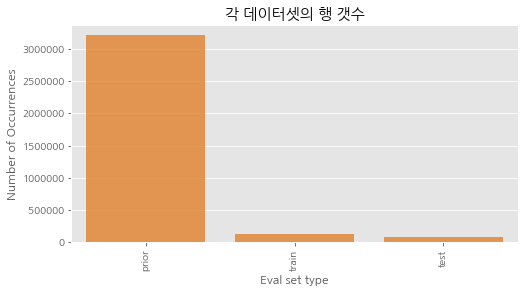

In [10]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('각 데이터셋의 행 갯수', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [11]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

In [12]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()
cnt_srs.head()

4    23986
5    19590
6    16165
7    13850
8    11700
Name: order_number, dtype: int64

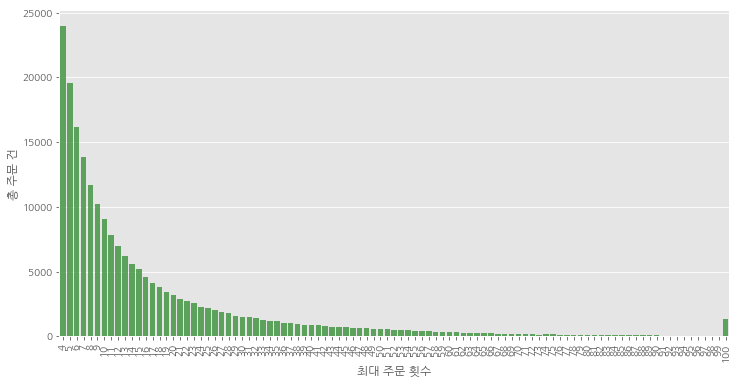

In [13]:
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('총 주문 건', fontsize=12)
plt.xlabel('최대 주문 횟수', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### 요일별 주문 횟수
토요일과 일요일에 주문이 가장 많고 수요일이 가장 적다.

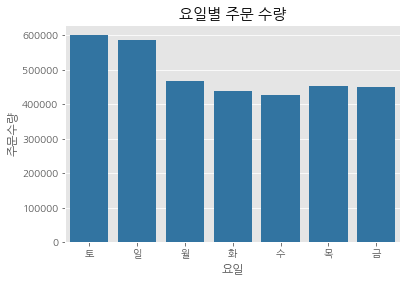

In [14]:
dow = ['토', '일', '월', '화', '수', '목', '금']

plt.figure(figsize=(12,4))
fig, ax = plt.subplots()
sns.countplot(x="order_dow", data=orders_df, color=color[0])
ax.set_xticklabels(dow)
plt.ylabel('주문수량', fontsize=12)
plt.xlabel('요일', fontsize=12)
plt.title("요일별 주문 수량", fontsize=15)
plt.show()

토요일 오후와 일요일 오전에 주문량이 많다.

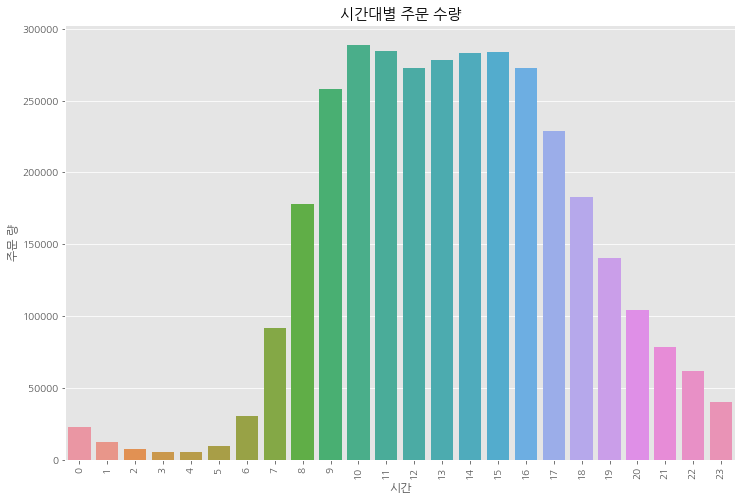

In [15]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df)
plt.ylabel('주문 량', fontsize=12)
plt.xlabel('시간', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("시간대별 주문 수량", fontsize=15)
plt.show()

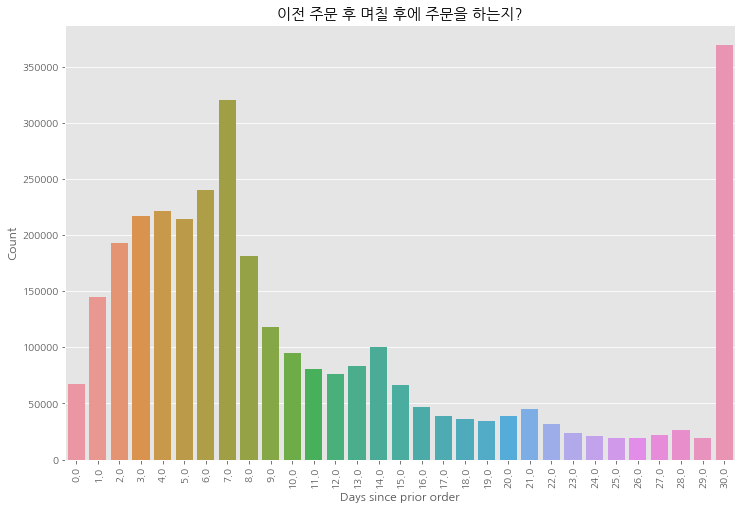

In [16]:
# 이전 주문이 없는 건은 첫 주문이라 추측해 본다.
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("이전 주문 후 며칠 후에 주문을 하는지?", fontsize=15)
plt.show()

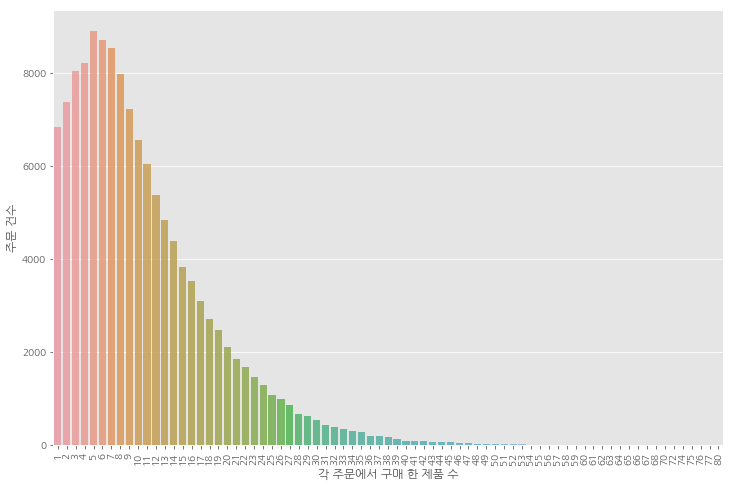

In [17]:
grouped_df = order_products_train_df.groupby(
    "order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('주문 건수', fontsize=12)
plt.xlabel('각 주문에서 구매 한 제품 수', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

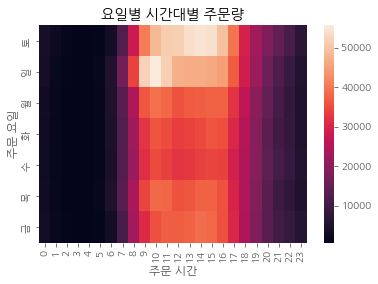

In [18]:
dow = ['토', '일', '월', '화', '수', '목', '금']

grouped_df = orders_df.groupby(
    ["order_dow", "order_hour_of_day"]
)["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot(
    'order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(20,6))
fig, ax = plt.subplots()

sns.heatmap(grouped_df)
ax.set_yticklabels(dow)

plt.ylabel('주문 요일', fontsize=12)
plt.xlabel('주문 시간', fontsize=12)
plt.title("요일별 시간대별 주문량")
plt.show()

In [19]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [21]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [22]:
order_products_prior_df = pd.merge(
    order_products_prior_df, products_df, on='product_id', how='left')

order_products_prior_df = pd.merge(
    order_products_prior_df, aisles_df, on='aisle_id', how='left')

order_products_prior_df = pd.merge(
    order_products_prior_df, departments_df, 
    on='department_id', how='left')

order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [23]:
cnt_srs = order_products_prior_df['product_name'].value_counts(\
    ).reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


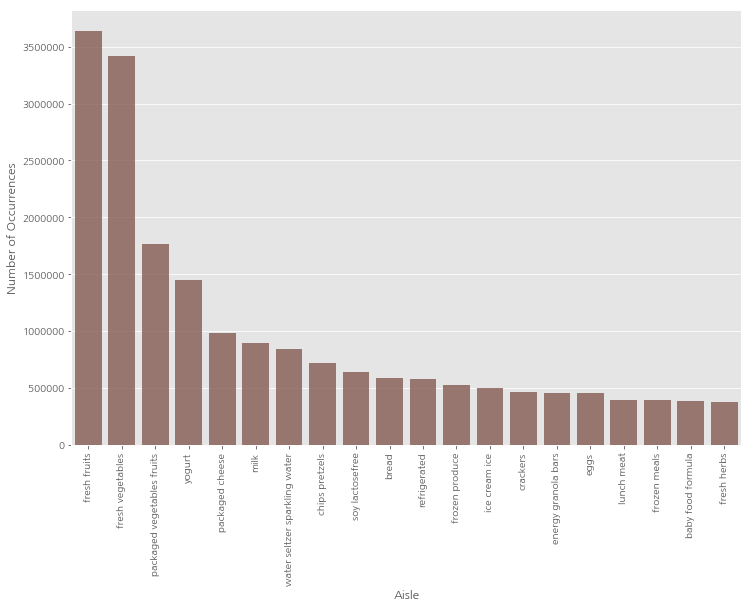

In [24]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

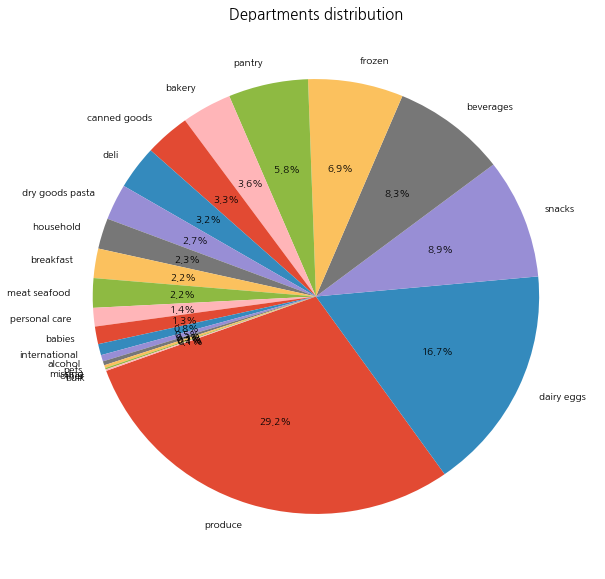

In [25]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

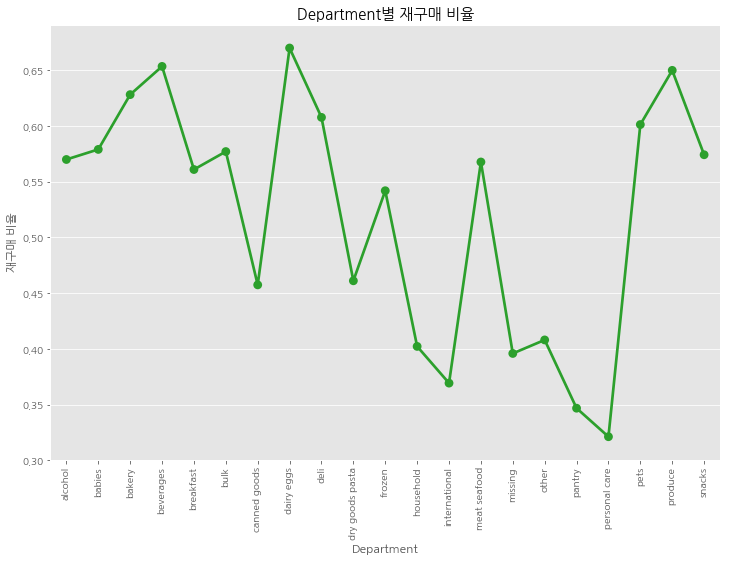

In [26]:
grouped_df = order_products_prior_df.groupby(
    ["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(
    grouped_df['department'].values, 
    grouped_df['reordered'].values, 
    alpha=0.8, color=color[2])
plt.ylabel('재구매 비율', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department별 재구매 비율", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


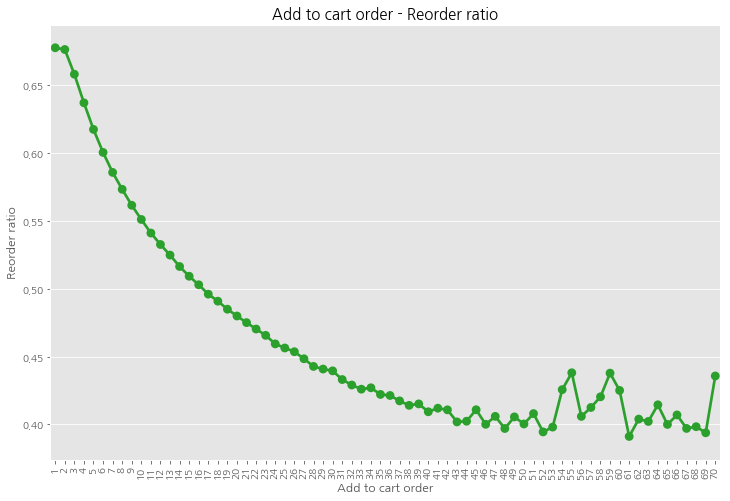

In [27]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(
    grouped_df['add_to_cart_order_mod'].values, 
    grouped_df['reordered'].values, 
    alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

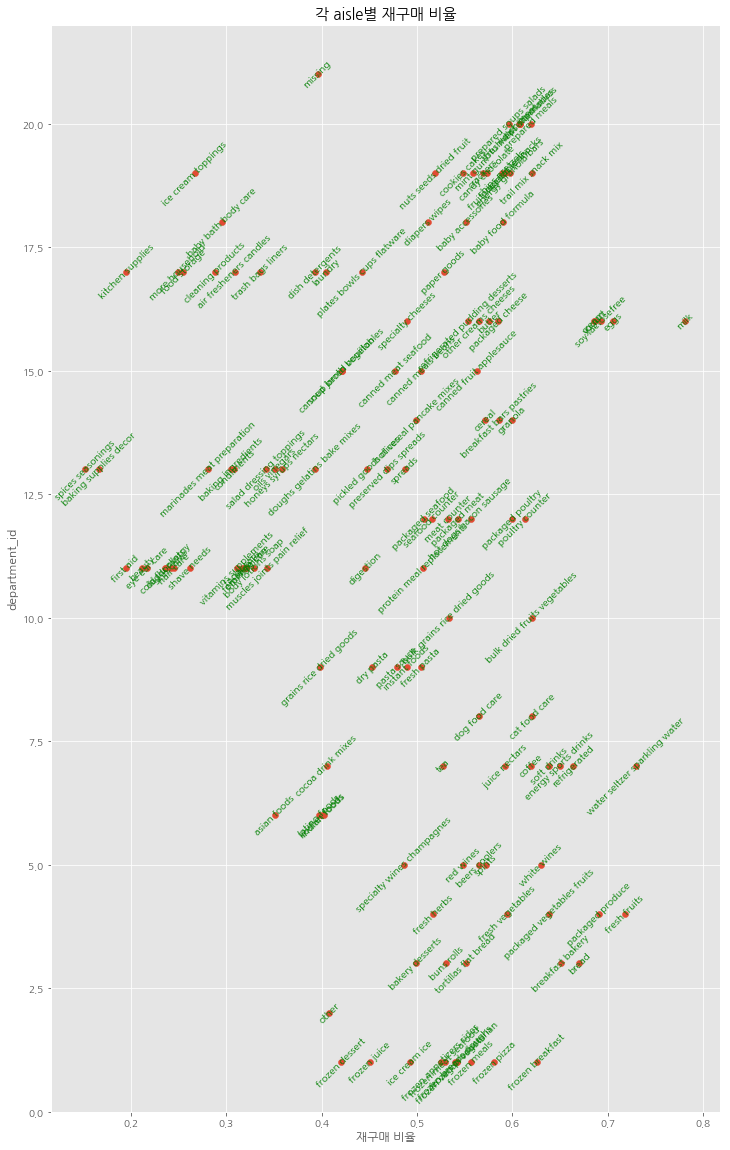

In [28]:
grouped_df = order_products_prior_df.groupby(
    ["department_id", "aisle"])["reordered"].aggregate(
    "mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('재구매 비율')
plt.ylabel('department_id')
plt.title("각 aisle별 재구매 비율", fontsize=15)
plt.show()

In [29]:
items_df = pd.merge(left = pd.merge(
    left=products_df, 
    right=departments_df, how='left'), right=aisles_df, how='left')
items_df.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [30]:
users_flow = orders_df[['user_id', 'order_id']].merge(
    order_products_train_df[['order_id', 'product_id']],
    how = 'inner', 
    left_on = 'order_id', 
    right_on = 'order_id')

users_flow = users_flow.merge(
    items_df, 
    how = 'inner', 
    left_on = 'product_id',
    right_on = 'product_id')

In [31]:
grouped = users_flow.groupby(
    ["department", "aisle"])["order_id"].aggregate(
    {'Total_orders': 'count'}).reset_index()

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


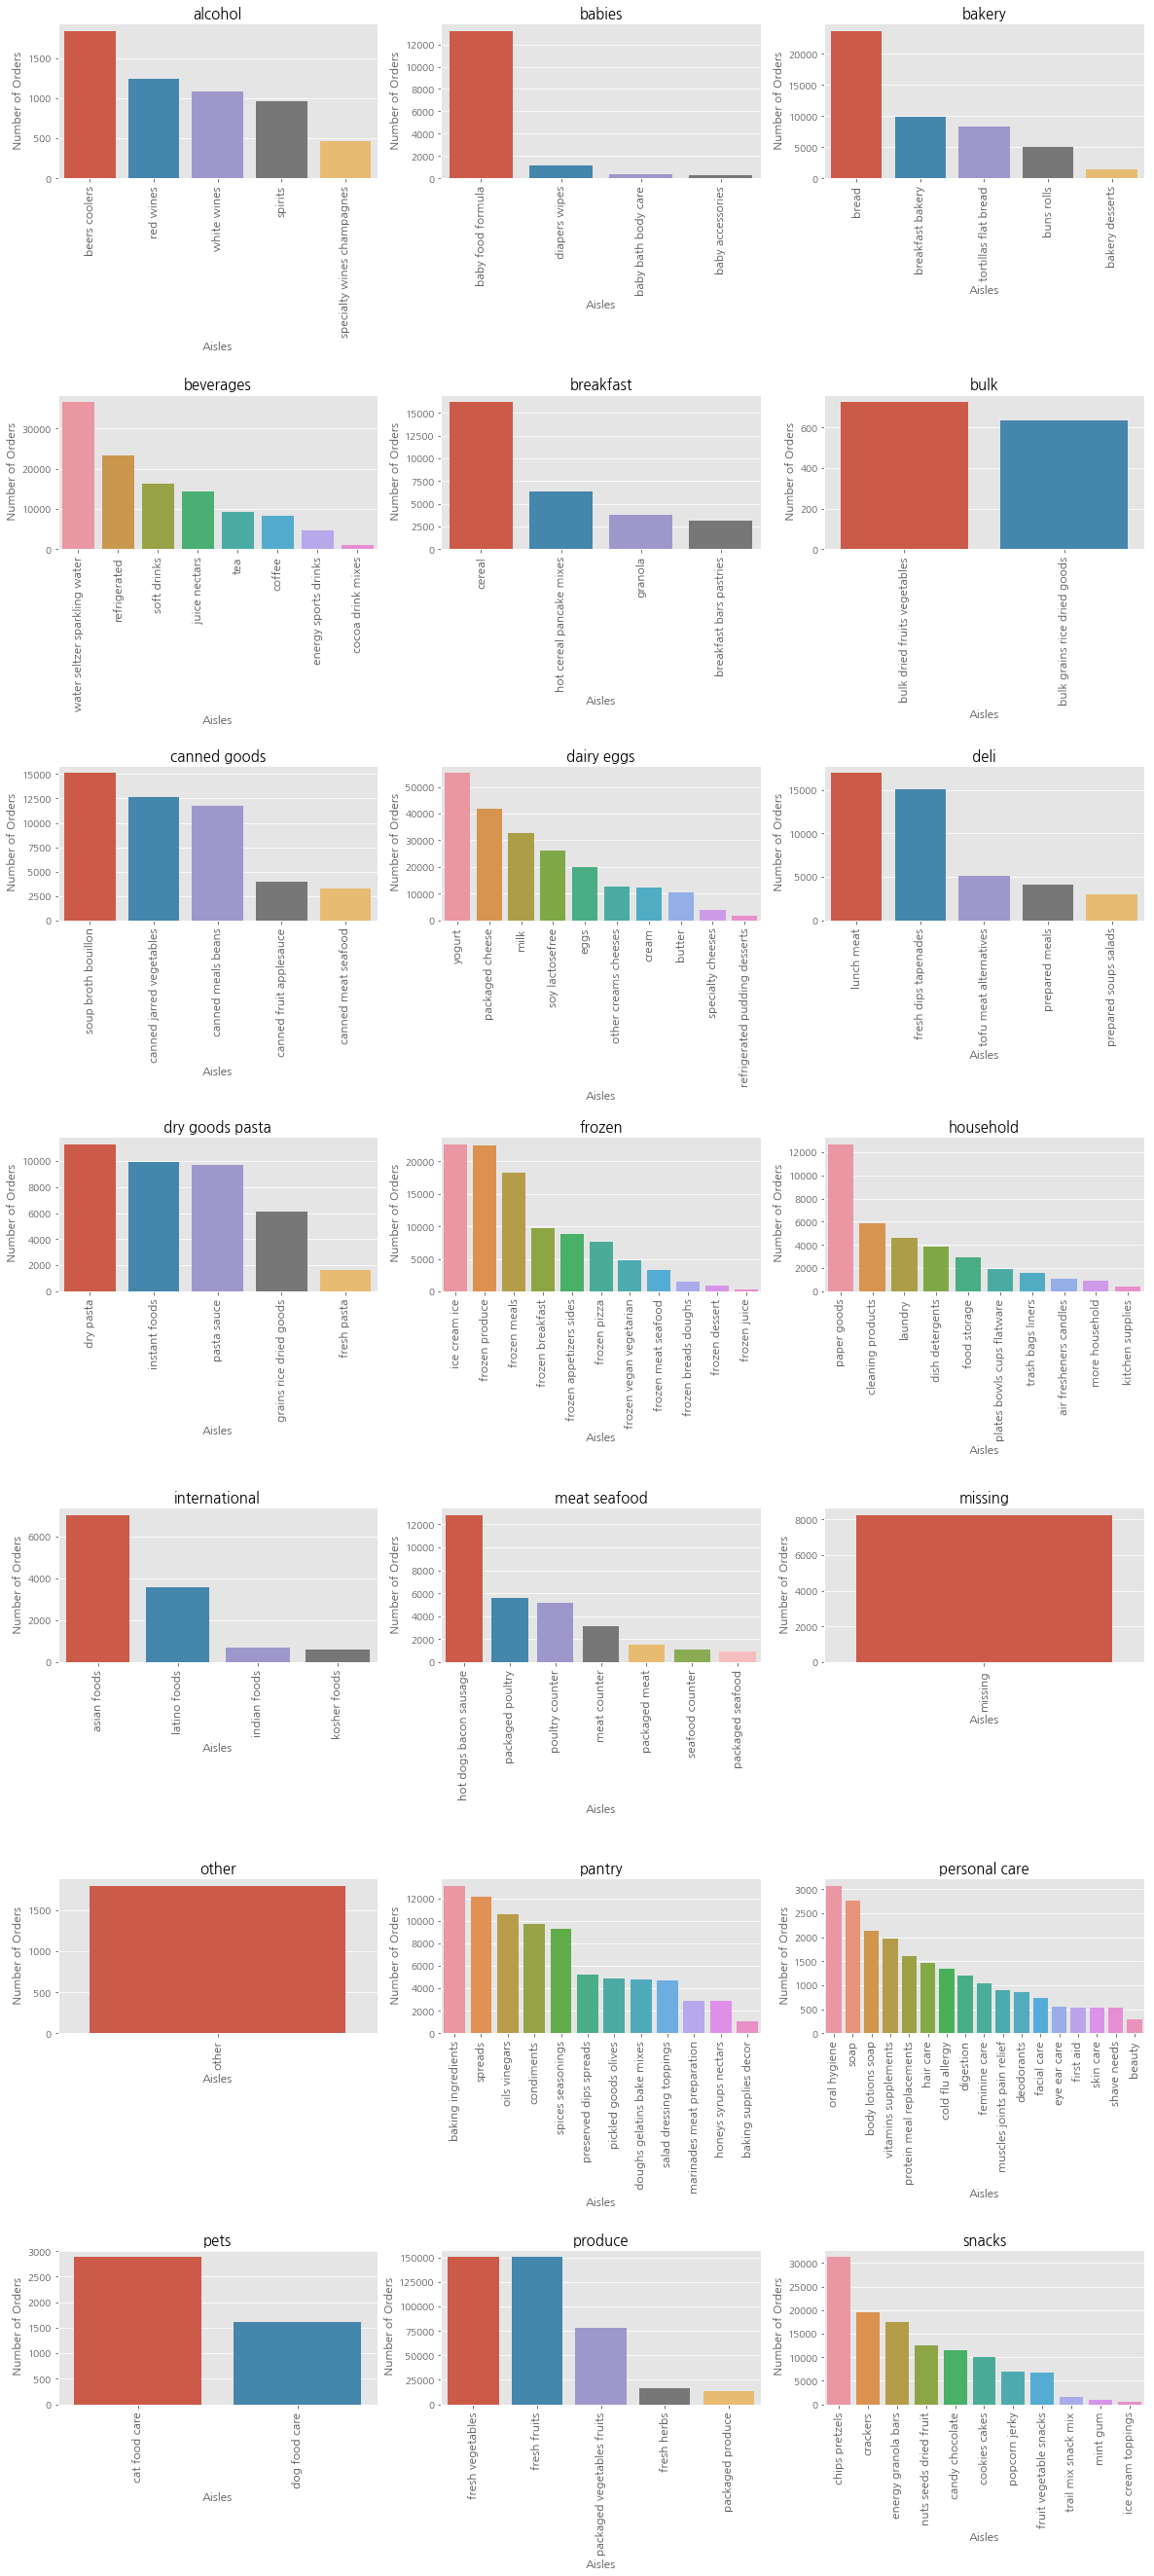

In [32]:
grouped.sort_values(by = 'Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel="Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)